<a href="https://colab.research.google.com/github/sa32953/advanced_deep_learning/blob/master/MMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [304]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds

2.4.1


Load the Datasets :In this case we use tfds command from Tensorflow to load the following 2 datasets.
1. MNIST
2. binary_alpha_digits

In [305]:
# Load Datasets
mnist = tfds.load('mnist', split='train', shuffle_files=True)
binary_alpha = tfds.load('binary_alpha_digits', split='train', shuffle_files=True)

# Print Basic Infos
print('Info about MNIST: ',mnist)
print('Info about Binary Alpha:',binary_alpha)

Info about MNIST:  <_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>
Info about Binary Alpha: <_OptionsDataset shapes: {image: (20, 16, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


Visualize MNIST:


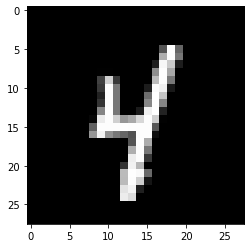

Visualize Binary Alpha:


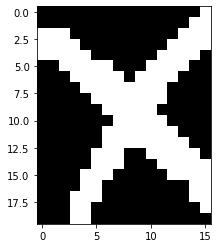

In [306]:
# Visualize 1 sample from each dataset

from matplotlib import pyplot
import numpy as np

###################
## Plot Function ##
###################

def print_sample(dataset):
  sample = dataset.take(1) # sample 1 
  for each in sample:
    image = each["image"] # Read the data under 'image' key
    image = np.array(image) # convert to np
    pyplot.imshow(image.reshape(image.shape[0],image.shape[1]), cmap=pyplot.get_cmap('gray')) # 3d to 2d arr
    pyplot.show()

print('Visualize MNIST:')
print_sample(mnist)
print('Visualize Binary Alpha:')
print_sample(binary_alpha)


In [307]:
############################
##   Domain Vector Prep   ##
############################

def domain_prep(dataset,count, img_height = 20, img_width = 16):

  instances = dataset.take(count) # sample a dataset
  i = 0
  for example in instances:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    
    # Rescale if using MNIST dataset
    if dataset == mnist:
      image = tf.image.resize(image, [img_height,img_width]) # New size same as Binary Alpha
    
    # Stack all samples from 1 domain into a p,q matrix where p = size of 1 sample and q = number of samples
    if i==0:
      domain_arr = np.array(image).reshape(np.multiply(img_height,img_width),1)
    else:
      domain_arr = np.hstack((domain_arr, np.array(image).reshape(np.multiply(img_height,img_width),1)))

    i+=1

  # Rescale array to 0~1, otherwise overflow
  return domain_arr/256.


In [308]:
count = 1000 # How many samples

X_m = domain_prep(mnist,count) # Domain 1
Y_b = domain_prep(binary_alpha,count) # Domain 2

# Checkpoint
print('Equality of Domain Characterics :', X_m.shape == Y_b.shape)
print('Size, count of Domain is', X_m.shape)


Equality of Domain Characterics : True
Size, count of Domain is (320, 1000)


In [309]:
from sklearn.metrics.pairwise import rbf_kernel

# Compute Gram matrices of Kernels
gram_K1 = rbf_kernel(np.transpose(X_m)) # K(x,x)
gram_K2 = rbf_kernel(np.transpose(Y_b)) # K(y,y)
gram_K3 = rbf_kernel(np.transpose(X_m),np.transpose(Y_b)) # K(x,y)

print('The Gram of X and Y looks like:\n',gram_K3)

The Gram of X and Y looks like:
 [[0.94507829 0.94477088 0.94485668 ... 0.94530585 0.94499554 0.94509676]
 [0.94381119 0.94351091 0.94355911 ... 0.94397872 0.94359045 0.94377612]
 [0.85587716 0.85524102 0.8556341  ... 0.8564874  0.85589732 0.85584302]
 ...
 [0.89843211 0.89808515 0.89815264 ... 0.89896345 0.89858719 0.89838247]
 [0.81892406 0.8183397  0.81869716 ... 0.81969888 0.81889562 0.81872976]
 [0.92760324 0.92733032 0.92734852 ... 0.92791774 0.92750787 0.92765055]]


In [310]:
# https://onurtunali.github.io/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html
# See above link for MMD equations

# Only the non diagonal elements are to be summed when computing from K(x,x) or K(y,y)
def sum_without_ij(gram):
  diag = np.eye(gram.shape[0]) # Identity of same size
  gram_without_ij = np.subtract(gram,diag) 
  sum = np.sum(gram_without_ij)

  # Mean as per eq (5) in link above
  mean = 1./(count*(count-1))*sum
  return mean

def sum_with_ij(gram):

  sum = np.sum(gram)
  
  # Mean as per eq (5) in link above
  mean = 2./(np.square(count))*sum
  return mean

In [311]:
MMD = sum_without_ij(gram_K1) - sum_with_ij(gram_K3) + sum_without_ij(gram_K2)
print('MMD result of MNIST and Binary Aplha Dataset is',MMD)

MMD result of MNIST and Binary Aplha Dataset is 0.08330785121896278


In [312]:
# Manual Cal
#a,b = X[:,0], X[:,3]

#gamma = 1.0/784.0
#norm = np.linalg.norm(np.subtract(a,b),2)
#norm = np.square(norm)
#print(norm)
#norm *=-gamma 
#np.exp(norm)
#print(np.exp(norm))